# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [7]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

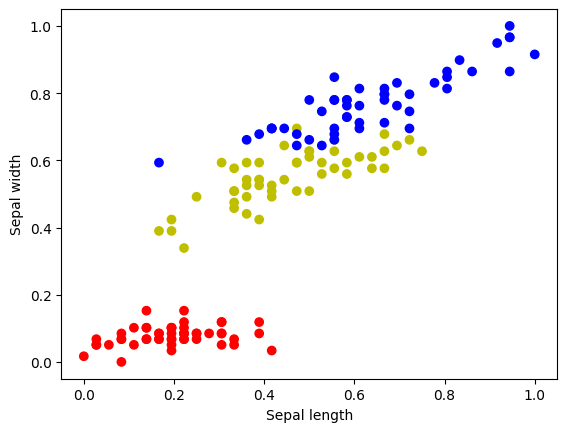

In [8]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [9]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [10]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [17]:
model = nn.Linear(in_features=2, out_features=3)  # 2 entradas e 3 saídas

In [23]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.1917, -0.2073],
                      [ 0.6291,  0.5535],
                      [-0.0359,  0.6214]])),
             ('bias', tensor([-0.3669,  0.0428,  0.4529]))])

### Fazendo um predict

In [24]:
out = model(X_tensor[:4,:]) # 4 amostras
out

tensor([[-0.4235,  0.2202,  0.4871],
        [-0.4129,  0.1852,  0.4891],
        [-0.3987,  0.1409,  0.4805],
        [-0.4004,  0.1422,  0.5026]], grad_fn=<AddmmBackward0>)

In [27]:
oo = F.softmax(input=out,dim=1)
oo

tensor([[0.1856, 0.3532, 0.4613],
        [0.1893, 0.3442, 0.4665],
        [0.1951, 0.3347, 0.4701],
        [0.1928, 0.3317, 0.4756]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [30]:
F.softmax(input=out,dim=1)*100

tensor([[18.5556, 35.3194, 46.1251],
        [18.9288, 34.4238, 46.6474],
        [19.5148, 33.4731, 47.0121],
        [19.2775, 33.1652, 47.5573]], grad_fn=<MulBackward0>)

### Predição da classe

In [31]:
prob, y_pred = torch.max(F.softmax(out, dim=1), dim=1)
print(y_pred)
print(prob)

tensor([2, 2, 2, 2])
tensor([0.4613, 0.4665, 0.4701, 0.4756], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [33]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [60]:
lr = 0.005

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.19594423472881317


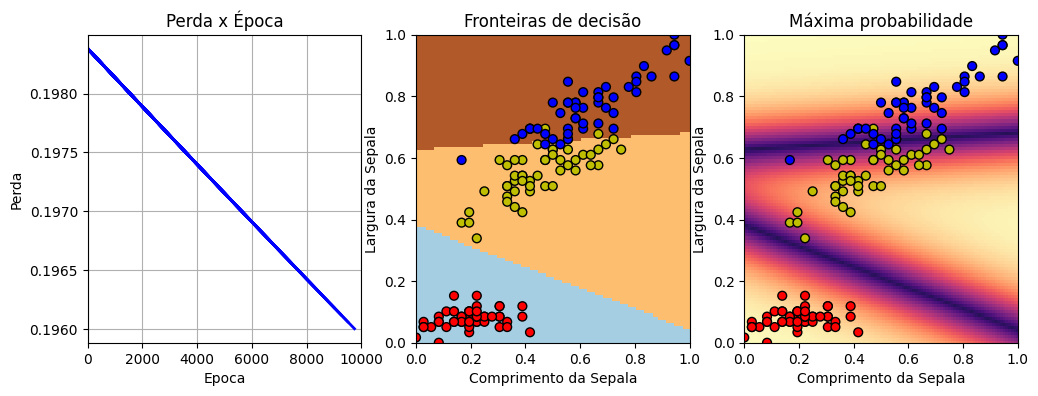

In [61]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(X_tensor)

    # calcula a perda
    loss = criterion(output, Y_tensor)

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [62]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.8231, -15.1832],
                      [  2.0987,  -0.6272],
                      [  1.1261,  16.7821]])),
             ('bias', tensor([ 7.3732,  1.8301, -9.0747]))])

### Salvando os parâmetros treinados

In [63]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [64]:
! ls ../models/

RegrLog_Iris.pt


In [65]:
nn.init.constant_(model.weight, 0)
model.state_dict()

OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 7.3732,  1.8301, -9.0747]))])

### Recuperando os pesos salvos

In [66]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.8231, -15.1832],
                      [  2.0987,  -0.6272],
                      [  1.1261,  16.7821]])),
             ('bias', tensor([ 7.3732,  1.8301, -9.0747]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [67]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [68]:
import pandas as pd

pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

2. Experimente refazer o treinamento com diferentes valores de learning rate

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
      - Amostra da classe 0 (vermelha).
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
      - Ambas as classes 1 e 2 (azul e amarela) são igualmente classificadas erroneamente, com 6% de erro.
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
      - Ambas as classes 1 e 2 (azul e amarela) são igualmente classificadas corretamente, com 94% de acertos.
    4. Qual é a amostra classificada erradamente, com menor probabilidade?
      - Amostra da classe 0 (vermelha).
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
  - A rede possui 9 parâmetros, 6 de camada densa e 3 de bias.
3. Quantas entradas e quantas saídas esta rede possui?
  - A rede possui 2 entradas e 3 saídas.
4. Como se pode calcular a acurácia a partir da matriz de confusão?
  - Verificar qual o valor de acertos para cada classe predita (coluna m x linha n onde m = n) e quanto ele representa sobre o todo (coluna m x linha n onde m = n + as demais linhas x colunas, isto é, coluna m x linha n onde m # n).
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max
    - Ela retorna o valor máximo entre todos os elementos recebidos no seu input (tensor). Para a rede neural treinada em questão, torch.max vai retornar a classe (0, 1 ou 2) que tem a maior probabilidade de acordo com o predict da rede neural e o valor dessa probabilidade.

## Principais aprendizados

- Mesmo variando o learning rate e conseguindo diminuir o erro calculado, a taxa de acertos totais (acurácia) se manteve muito próxima ou a mesma nos diferentes treinamentos. Isso parece mostrar que é precisa adicionar mais camadas e, consequentemente, mais complexidade a essa rede neural para tentar ter uma acurácia melhor, uma vez que a fronteira entre algumas saídas não conseguiu representar bem a separação dos dados preditos quando definida a partir do modelo atual mais simples (linear).